# Labor Detection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import sys
sys.path.insert(1, "C:/sers/jaege/PycharmProjects/labour-katharina");
from labor_katharina import contraction_features
import datetime
import seaborn as sns

In [3]:
def make_autopct(values, unit=""):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d} {u:s})'.format(p=pct,v=val,u=unit)
    return my_autopct

In [4]:
users = pd.read_pickle('./data/users.pkl')
recordings = pd.read_pickle('./data/recordings.pkl')
contractions = pd.read_pickle('./data/contractions.pkl')

## Subjects 

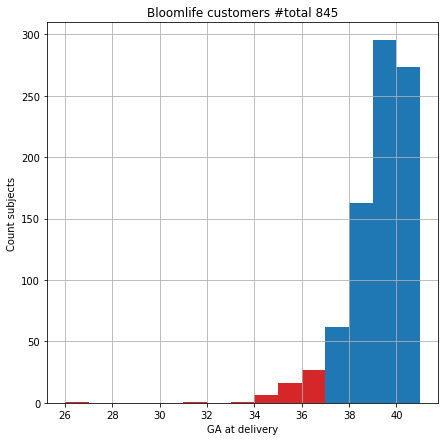

In [5]:
fig = plt.figure(figsize=(7,7))
ga_birth = users['ga_delivery'].apply(np.floor)
n, bins, patches = plt.hist(ga_birth, np.arange(int(ga_birth.min()), int(ga_birth.max())+1))
[patches[x].set_fc('C3') for x in np.where(bins<37)[0]];
plt.xlabel('GA at delivery');
plt.ylabel('Count subjects');
plt.grid();
plt.title('Bloomlife customers #total ' + str(int(n.sum())));


## Recordings

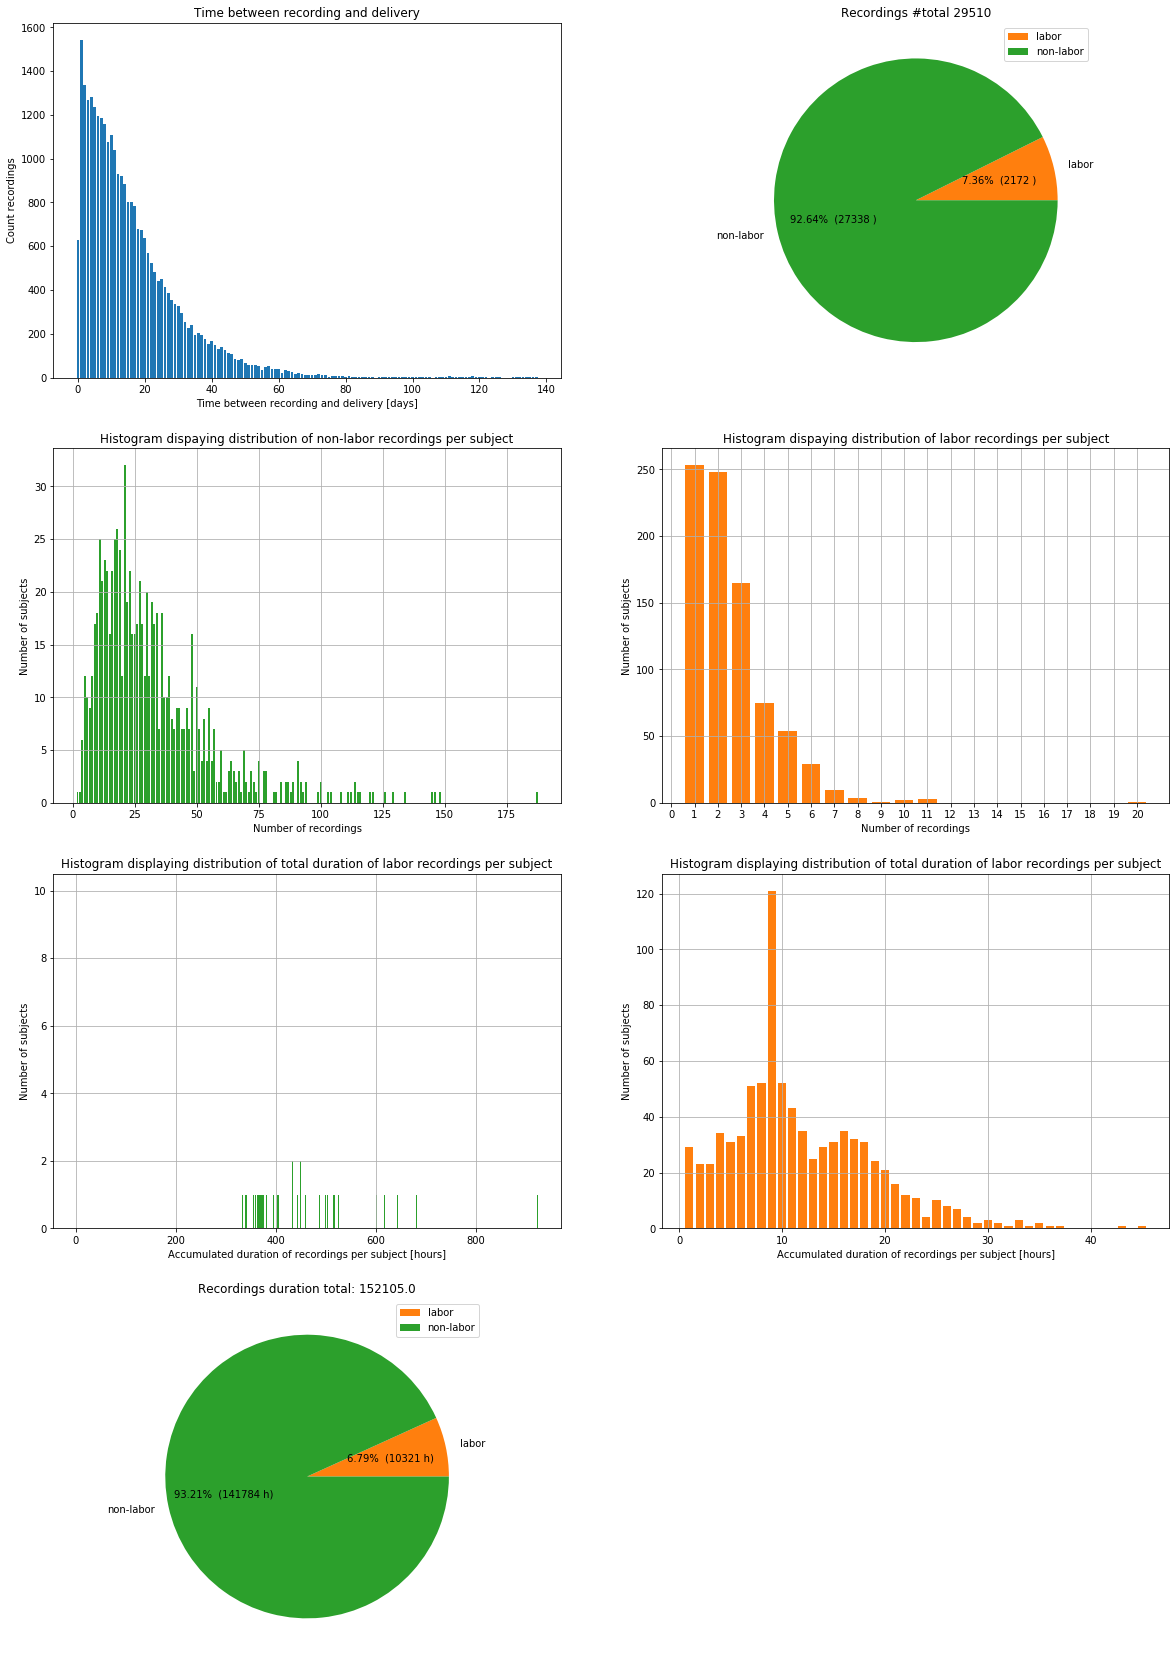

In [6]:
#plot time between recording and delivery
plt.figure(figsize= (20,30))
ax = plt.subplot(4,2,1);
delta_rec = (recordings['baby_birthdate']-recordings['created_at'].dt.date)
delta_rec= delta_rec.values/(1000000000*3600*24);
x,count = np.unique(delta_rec, return_counts=True);
plt.bar(x.astype(int), count, color='C0')
ax.set_xlabel('Time between recording and delivery [days]')
ax.set_ylabel('Count recordings');
ax.set_title('Time between recording and delivery');

#plot percentage of labor and non-labor recordings
ax = plt.subplot(4,2,2);
sizes =[recordings[recordings['labor'] == 1].shape[0], recordings[recordings['labor'] == 0].shape[0]];
labels = 'labor', 'non-labor';
wedges, text, autotext = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes), colors=('C1', 'C2'));
ax.set_title('Recordings #total '+ str(np.sum(sizes)));
ax.legend(wedges,labels);


#histogram of non-labor recordings per subject
ax = plt.subplot(4,2,3);
rec_nonLabor = recordings[recordings['labor'] == 0];
_, count_nonLaborRecs = np.unique(rec_nonLabor['user_id'], return_counts=True);
x, count_nonLaborSubj = np.unique(count_nonLaborRecs, return_counts=True);
plt.bar(x, count_nonLaborSubj, color='C2')
ax.set_title('Histogram dispaying distribution of non-labor recordings per subject');
ax.set_xlabel('Number of recordings');
ax.set_ylabel('Number of subjects');
plt.grid();


# histogram of labor recordings per subject
ax = plt.subplot(4,2,4);
rec_labor = recordings[recordings['labor'] == 1];
_, count_laborRecs = np.unique(rec_labor['user_id'], return_counts=True);
x,count_laborSubj = np.unique(count_laborRecs, return_counts=True);
plt.bar(x, count_laborSubj, color='C1')
plt.xticks(np.arange(x.min()-1,x.max()+1));
ax.set_title('Histogram dispaying distribution of labor recordings per subject');
ax.set_xlabel('Number of recordings');
ax.set_ylabel('Number of subjects');
plt.grid();


#histogram of duration of all non-labor recordings per subject
ax = plt.subplot(4,2,5);
nl_dr = rec_nonLabor[['duration', 'user_id']].groupby(['user_id']).sum()
nl_dr['duration_hours'] = nl_dr['duration'].dt.total_seconds()//3600
x,count = np.unique(nl_dr['duration_hours'], return_counts=True);
plt.bar(x, count, color='C2');
ax.set_title('Histogram displaying distribution of total duration of labor recordings per subject');
ax.set_ylabel('Number of subjects');
ax.set_xlabel('Accumulated duration of recordings per subject [hours]');
plt.grid();


#histogram of duration of all labor recordings per subject
ax = plt.subplot(4,2,6);
l_dr = rec_labor[['duration', 'user_id']].groupby(['user_id']).sum()
l_dr['duration_hours'] = l_dr['duration'].dt.total_seconds()//3600
x,count = np.unique(l_dr['duration_hours'], return_counts=True);
plt.bar(x, count, color='C1');
ax.set_title('Histogram displaying distribution of total duration of labor recordings per subject');
ax.set_ylabel('Number of subjects');
ax.set_xlabel('Accumulated duration of recordings per subject [hours]');
plt.grid()

#plot percentage of labor and non-labor total durations
ax = plt.subplot(4,2,7);
sizes =[(l_dr['duration'].dt.total_seconds()/3600).sum(), (nl_dr['duration'].dt.total_seconds()/3600).sum()]
labels = 'labor', 'non-labor';
#wedges, text, autotext = plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=('C1', 'C2'));
wedges, text, autotext = plt.pie(sizes, labels=labels, autopct=make_autopct(sizes, 'h'), colors=('C1', 'C2'));
ax.set_title('Recordings duration total: '+ str(np.round(sum(sizes))));
ax.legend(wedges,labels);



Note: Woman with 20 labor recordings performed measurement every 1-2 hours the two days before delivery

## Contraction features

window size: 1024s/ 2048s/ 3072s <br>
contraction is in window if peak is in window


- number of contractions
- gestational age
- days to delivery
<br>
<br>

Contraction duration:
- minimal duration 
- maximal duration
- mean duration 
- median duration 
- 1st quartile of durations
- 3rd quartile of durations
- standard deviation of durations
- rmssd of durations 
<br>
<br>

Delta time between two consecutive contractions:
- minimal time between contractions 
- maximal time between contractions
- mean time between contractions 
- median time between contractions 
- 1st quartile of times between contractions 
- 3rd quartile of times between contractions 
- standard deviation of times between contractions
- rmssd of times between contractions

Standard deviation and maxmin is None if less than 2 observations are in the window. <br>
RMSSD is None if less than 3 observations are in the window. <br>
(observatione = duration of contraction/ time between two consecutive contractions)



TO CHECK:
- data (bytea)
- data_json (jsonb)
- delta_start_to_onset 
- delta_onset_to_peak
- delta_peak_to_offset
- num_iup_samples (# contractions?)
- if there is kind of amplitude
- check in paper what are time features

TODO:
- compute for a few subject the features in windows and plot how they evolve over time until labor
- feature analysis to remove outliers
- 2048s window

EXPECTATIONS:
- Std of time between contractions higher in non-labor


Thoughts:
- sd makes only sense if more contractions in window -> larger window
- max-min macht auch nur sinn wenn keine outlier

In [7]:
window_size = 1024; #feature window 1024s/ 2048s/ 3072s

### One subject

### Default values for NaNs (if feature needs more contractions than exist in window)

Duration:
- min: 35s
- max: 2:40min

Time between peaks:
- min: 40s

Calculate corner cases for all features according to min and max values of duration and time between peaks that can be measured. Edge values dependent on window size. See _:\Users\jaege\OneDrive\Documents\Bloomlife\Data\Customer\contraction_features_CornerCases.xlsx_

### Subset of subjects

In [26]:
window_size = 2048
users_sub20 = users[users['ga_delivery'] > 37].head(20);
features_sub20 = pd.DataFrame(columns=['count', 'duration_min', 'duration_max', 'duration_mean', 'duration_median',
                                             'duration_quantile_1', 'duration_quantile_3', 'duration_sd', 
                                           'duration_maxmin', 'duration_rmssd',
                                            'timebetween_min', 'timebetween_max', 'timebetween_mean', 'timebetween_median',
                                             'timebetween_quantile_1', 'timebetween_quantile_3', 'timebetween_sd', 
                                       'timebetween_maxmin', 'timebetween_rmssd',
                                       'session_id', 'labor', 'start_window', 'user_id'])

for index, rowR in users_sub20.iterrows():
    userID = rowR['user_id']
    contractions_sub = contractions[contractions['user_id'] == userID]
    recordings_sub = recordings[recordings['user_id'] == userID]
    features_sub = contraction_features.extract(recordings_sub, contractions_sub, window_size, corner=False)
    features_sub['user_id'] = userID
    features_sub20 = pd.concat([features_sub20, features_sub], ignore_index=True, sort=False)

# add gestational age and days to delivery features
features_sub20['gestational_age'] = [((sw.date()-dd).days+280.0)/7.0 for sw,dd in zip(features_sub20['start_window'], users.loc[recordings.loc[features_sub20['session_id'], 'user_id'], 'due_date'])];
features_sub20['days_to_delivery'] = [(bb-sw.date()).days for sw,bb in zip(features_sub20['start_window'], users.loc[recordings.loc[features_sub20['session_id'], 'user_id'], 'baby_birthdate'])];


### All subjects

In [9]:
window_size = 1024
features = pd.DataFrame(columns=['count', 'duration_min', 'duration_max', 'duration_mean', 'duration_median',
                                             'duration_quantile_1', 'duration_quantile_3', 'duration_sd', 
                                           'duration_maxmin', 'duration_rmssd',
                                            'timebetween_min', 'timebetween_max', 'timebetween_mean', 'timebetween_median',
                                             'timebetween_quantile_1', 'timebetween_quantile_3', 'timebetween_sd', 
                                       'timebetween_maxmin', 'timebetween_rmssd',
                                       'session_id', 'labor', 'start_window', 'user_id'])
total = users.shape[0]
i = 1
for _, rowR in users.iterrows():
    userID = rowR['user_id']
    contractions_sub = contractions[contractions['user_id'] == userID]
    recordings_sub = recordings[recordings['user_id'] == userID]
    features_sub = contraction_features.extract(recordings_sub, contractions_sub, window_size, corner=False)
    features_sub['user_id'] = userID
    print(i, '/', total, ':', userID)
    i = i+1

# add gestational age and days to delivery features
features['gestational_age'] = [((sw.date()-dd).days+280.0)/7.0 for sw,dd in zip(features['start_window'], users.loc[recordings.loc[features['session_id'], 'user_id'], 'due_date'])];
features['days_to_delivery'] = [(bb-sw.date()).days for sw,bb in zip(features['start_window'], users.loc[recordings.loc[features['session_id'], 'user_id'], 'baby_birthdate'])];


1 / 845 : 01VafS7FhbamWUIitmlZYaDE90F3
2 / 845 : 08Y7hVvLbMNWHGAPhUfecrH4auY2
3 / 845 : 0HRIV2DATxZuOk0g46ZNitrNZo12
4 / 845 : 0jpuDqZ1tFfxgdbb8B9FhScIzvt1
5 / 845 : 0MXOFXfrb6VwQMU4qt8a2YdqT1s2
6 / 845 : 0oTMSQVVORYAI9PcEHxXYzvErmU2
7 / 845 : 0rIg4A4Ar7XlOkYUBaS3h0PF3OQ2
8 / 845 : 0UUyBcXPZ2fzDjcTJpLT3EH7al43
9 / 845 : 0XoxRgIwhtMRNHY8hFcAtgbMUPc2
10 / 845 : 111uaulAsph3RDtVycNlbCVANO33
11 / 845 : 13oEUbXqMzMWI9LnEZoMUG4QaZ52
12 / 845 : 1AudAsqv5ogr1ZQEFel6VY2G6G92
13 / 845 : 1BGLswpyc2TqqPEynlwetHUCQXg1
14 / 845 : 1dLiyg1I91PFKjvhZz8NYpGnJP12
15 / 845 : 1FaiMlvCc5aDVMA10aGtJB8THp93
16 / 845 : 1gjGC788dfa6Z15TvCl5MZr9kbA2
17 / 845 : 1h7xLrQFlFXAytb8IJysJG4uoTL2
18 / 845 : 1NyAYJALz4cp4dZsblbw82WA6xp1
19 / 845 : 1rQmFo3VkMZiNZLpGe63RTwN8yx2
20 / 845 : 1SwaF1lPrldE59AcKokGuGpOcao1
21 / 845 : 1X2hQuBpRmSlKqMu116dpNFGmQG2
22 / 845 : 1ZU0psTu82gqVcwIwnpNcHuWT3K2
23 / 845 : 21LzIoHNUGYtjxgV6rQ1BMCZhq53
24 / 845 : 2BDLo9CPD8US12SbB5YdxVbw5pp1
25 / 845 : 2BXMTIjz2fWPHqYWxlA3ZZyfhJ22
26 / 845 

204 / 845 : CpHhzsQLEvYFKCndfRa0yIZnEHG2
205 / 845 : csulQkK8zbSfojwVg81SA0RLHey1
206 / 845 : CVC4oUxDxPTgcbU7kSPInC3ItEr2
207 / 845 : cWF1YK7vq1ZOPUHNn6lD72xlQKD2
208 / 845 : d1exUgBHHfRxxm8sfUsnMWz2lw52
209 / 845 : d1qElXAfd0az4KpUrJoY2JMe7hs1
210 / 845 : d2xDwnQqzXOUHEKrI4vvZvE3j9A3
211 / 845 : D3uZfS2gDiUVTlACeHS2sLXFQOp2
212 / 845 : D8arwL1PaWVGnn3fyCCN3PbVVfn2
213 / 845 : d8N3njRtYzXTXPHEQDOXRkM0NNp1
214 / 845 : D9dnKSrJ53T8ktRm60DeD7JScvV2
215 / 845 : da2zlsuHqmPM10k6vqHZmEzv87W2
216 / 845 : DBm9LeFGboaoPUsfkFABbxj7mcD2
217 / 845 : dD3b8PsggWh6Bn0IrKmbCmdkR0H2
218 / 845 : dDEWAh3yNKZMCx3UKJFCuns9I6n1
219 / 845 : deN83F51U5XMRaDiQgoyYj0CDwG3
220 / 845 : dEt8Bbdd9AeEzEMqQ74uCF52aBE3
221 / 845 : DezhoHLQlvaMbiCG5VNKC5hGqcR2
222 / 845 : dHFeVENj1aYzeNDyignuUr9fOb02
223 / 845 : dhykH9D1SXa1vPjCj1ajti8LBzA3
224 / 845 : DiVwC8Wa4BhYt4MhJjMGu1cyr4q2
225 / 845 : DJC6EVztzwQAMMhvWd90NfR7KVF3
226 / 845 : dJCNjdcNlbUOfU4FgN8ArkjMAWg1
227 / 845 : DjpIurP2jPRAXoy4oMUi85GPf1F3
228 / 845 : dLf6

404 / 845 : K4sc2hIg4PYrhK7w41Dusak1zPq1
405 / 845 : k8DVgZltvOeSKArsAksrIh7b5vl2
406 / 845 : KarHSJR3miQgz5n1FEHMt48W84Y2
407 / 845 : kdj3IbZqSQZq2dO5T6j6n7o8aHJ3
408 / 845 : keNFYo9lHUTfIcByIlC7CrL6scS2
409 / 845 : kEVjwAwvhYUGFs5KR6GuJSxQwd23
410 / 845 : KgglLJvwYSXjvcUG7ov91XkOIEt2
411 / 845 : khbG1xIJ7Gf2l1zyJ1jzAylnWR13
412 / 845 : kJ5wr7IxVBfQN6C8tsR5g36Vh2q1
413 / 845 : kJZXKiMyerPDhPWSaiYCvlg7Yqz2
414 / 845 : KLIMsLBrpZWfrqlu5WiJ5sUiVYz1
415 / 845 : kLOJV9zDwdMzmLkiR5zkh7R593x2
416 / 845 : kLV6jCypU7TesuAZcMJagaxwcv82
417 / 845 : KMpn8SkavnX2BV9c2WDkBlkjpCc2
418 / 845 : kojsIe5DvtbM4otUF2DiiY31P482
419 / 845 : KpBgiY55P3OI0wNdPIuZbibD3e83
420 / 845 : KpGqvauktsgGMonT67ZvmynHk9e2
421 / 845 : kpNC9GYYv9NNEjaol7oRBSDidBh1
422 / 845 : KpsOOUcXWMYdcC6kfjm1yW2yw1v1
423 / 845 : kq5apN3MLNMF3YouX0tiUlJpWEJ2
424 / 845 : KqYodby36lbTBNSHOI8BaY1BO6k1
425 / 845 : Ktn9kd0ZwSguqCKb3JRkb8KQbeu1
426 / 845 : KUubtslmk7VLSWW8eStOe3PaqPu1
427 / 845 : KvAihmegWYg6MoGzdNzzVAhwYDQ2
428 / 845 : KVcl

604 / 845 : rAUchUc4WFQ4CJCHjpYHPXfRMAS2
605 / 845 : RbG8Gu19cZPkqbRHFQ9xDdpKiqy1
606 / 845 : RCNJWEL4I0UbVnaI7mmtywrJ8D42
607 / 845 : rcue4NnkI4cpNmdua0SaEyHvVVp1
608 / 845 : RdeRgWb9v1XIE0BEFzvjJJtBkVf2
609 / 845 : rDuS45kOdfdVtouXonfj4BKB4kU2
610 / 845 : RdXUlNDpb9OhFd3hYlbEej2kFJq2
611 / 845 : rEyJqJMLsReFBg65b17qt6bbUgW2
612 / 845 : rjuv7hZhZGXLzpTfTfdEYWTFVGp1
613 / 845 : Rk4wKBGLfeUjqcbxyC2XFFXGoLz2
614 / 845 : Rkr6x3DU7QfVf6DDH9UwtvBnShG2
615 / 845 : rLUmw6kFLBd9NkStZk6eweib0IH2
616 / 845 : RN6nKq5lY3XODkf1LygtpPhWKPK2
617 / 845 : RndNHCk8XAgHWSFbYN0hsNIENTa2
618 / 845 : roTbzEtEtySEP3jX0iBmEFhzuUz2
619 / 845 : rPoXdgFMbZSym4XtLBcTaZhzBsU2
620 / 845 : RR7HIulZgzdNSp8Ae4sZF5FGU2h2
621 / 845 : RsfFU24O9bVNc68m8FggTmK6Xus1
622 / 845 : rT8wKwpgErPGdyKaHiKJVmcO2rq2
623 / 845 : RUqPzuUitrO2EtIysoKR3SraBks2
624 / 845 : RVANGEeBQpekSuk6u3Zt65G4uzm2
625 / 845 : RVn5e0uzLIM9pNVbJRYWimaz1pB2
626 / 845 : RVSKOurRwnUW4Uy71aXaWXvjwFw2
627 / 845 : rYSHUdJO53MgmrIW2zspe4p9ha92
628 / 845 : s0Tp

804 / 845 : yEv7paeYbGTkMcntoB8NKskf85M2
805 / 845 : YFNq6M22jRY1xbK1HG2NrJYgP8u2
806 / 845 : yhd82h8RAAQOgmltLNeEqv5UXw73
807 / 845 : yhpSKIMF8AfwoUu50MfrmzJGMGn2
808 / 845 : YiTCsAxIZNUx9FNx4SJFQJyfNMG2
809 / 845 : ylV84PShPmY55d7cptvIF6GCyaf1
810 / 845 : ymoO7u9fVibg1yURUchWQtuVYIj1
811 / 845 : YNTXM5d5wjdlqHOLfee7oPCEmmx2
812 / 845 : Ynx8gDVBrFTCMJdYt8XDDESDb6V2
813 / 845 : YOeXUQftine1IbejW1XX9DMtOmv2
814 / 845 : yp7c4CNKNefI0XmLFCQhSsaU0273
815 / 845 : yQvwv5ruHVTZIAZayYhEBQijhTo1
816 / 845 : yRvIC7wKogdCRmyXZmBTmWu61wC2
817 / 845 : YSDMSSiRwyUPsvQWHzrSvfsCNCC3
818 / 845 : ySDpslLsQYP44q8Al3poVafLtwS2
819 / 845 : Yx0HknBFNJdvKQIrrPyXEiMMnVY2
820 / 845 : YZdkDe5NeGaJPRQOAks60RmM86o1
821 / 845 : Z0BEHA55Qdgg29i7MqrNP1nvCGk1
822 / 845 : Z7h8gWz4vchVGoc3wdZLtmSJReg1
823 / 845 : zAYTbMuUBQZ4DUKlFNxLgzZ19jG2
824 / 845 : ZcboG3mHEQRPFhliHRiCUBNDS693
825 / 845 : zcofYe96dNUTMqmx1XXkoYSM6ei2
826 / 845 : zdUwvHmOo8WE3ID3LGNPrZGZiMm1
827 / 845 : ZDXWWxd0M3h1bUEIfLNqSpqtsLn2
828 / 845 : zEia

In [12]:
features.to_pickle('./data/noEdge/windowsize1024/features.pkl')

started: 14:40